# K-means聚类

在这个任务中，我们会利用一个$2D$数据集来完成K-means聚类

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

## Visualize data

In [7]:
mat = loadmat('./data/ex7data2.mat')
data = pd.DataFrame(mat.get('X'), columns=['X1', 'X2'])
data.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


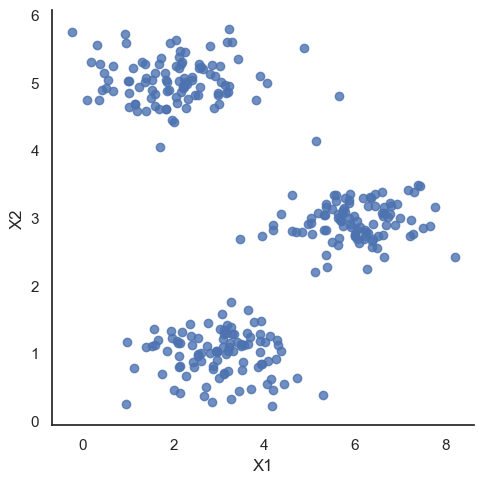

In [8]:
sns.set_theme(context='notebook', style='white')
sns.lmplot(x='X1', y='X2', data=data, fit_reg=False)
plt.show()

## 2D K-means

In [9]:
# chose k samples randomly
def random_init(data, k):
    return data.sample(k).values

通过肉眼观察数据集，我们可以选择$K=3$

In [10]:
k = 3
init_centroids = random_init(data, k)
init_centroids

array([[2.20321658, 4.94516379],
       [2.07291709, 1.16763851],
       [2.28664839, 5.0076699 ]])

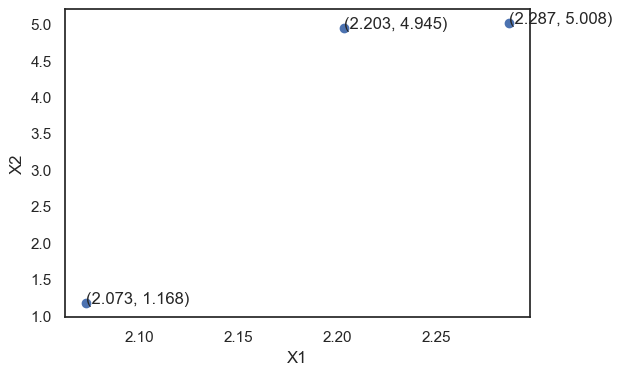

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(x=init_centroids[:, 0], y=init_centroids[:, 1])
ax.set_xlabel('X1')
ax.set_ylabel('X2')

for i, node in enumerate(init_centroids):
    ax.annotate('({:.3f}, {:.3f})'.format(node[0], node[1]), node)
plt.show()    

接下里我们实现：给定聚簇点，将每一个样本分配给距离最近的聚簇点

In [12]:
def nearest_cluster_dis(x, centorids):
    distances = np.apply_along_axis(func1d=np.linalg.norm, axis=1, arr=centorids - x)
    return np.argmin(distances)

def assign_cluster(data, centorids):
    return np.apply_along_axis(lambda x : nearest_cluster_dis(x, centorids),
                               axis=1, arr=data.values)

接着是更新数据集中每个样本的类别，并计算新的聚簇点

In [13]:
def combine_data_c(data, color):
    data_with_c = data.copy()
    data_with_c['c'] = color
    return data_with_c

def new_centroids(data, color):
    data_with_c = combine_data_c(data, color)
    return data_with_c.groupby('c', as_index=False).mean().sort_values(by='c').drop('c', axis=1).values

代价函数

<img src='./img/1.png'>

In [14]:
def Cost(data, centroids, color):
    m = data.shape[0]
    data_belong_c = centroids[color]
    distances = np.apply_along_axis(func1d=np.linalg.norm, axis=1,
                                    arr=data.values-data_belong_c)
    return distances.sum() / m

最后，我们编写K-means的代码，并加入**随机初始化**

In [15]:
def k_means_iter(data, k, epoch=100, delta=0.0001):
    centorids = random_init(data, k)
    cost, color = [], []

    for i in range(epoch):
        color = assign_cluster(data, centorids)
        centorids = new_centroids(data, color)
        cost.append(Cost(data, centorids, color))
    
    return color, centorids, cost[-1]

# run k_means_iter for 'n_init' times, each run start with random initialize
def k_means(data, k, epoch=100, n_init=10):
    tries = [k_means_iter(data, k, epoch) for _ in range(n_init)]
    costs = [el[-1] for el in tries]
    least_cost_idx = np.argmin(costs)
    return tries[least_cost_idx]

为了直观地看到K-means的迭代过程，我们按迭代次数逐渐递增来展示聚类结果

In [16]:
def draw_res(data, k, epoch):
    final_color, final_centorids, least_cost = k_means_iter(data, k, epoch)
    data_with_color = combine_data_c(data, final_color)
    
    sns.lmplot(x='X1', y='X2', hue='c', data=data_with_color, fit_reg=False)
    plt.show()

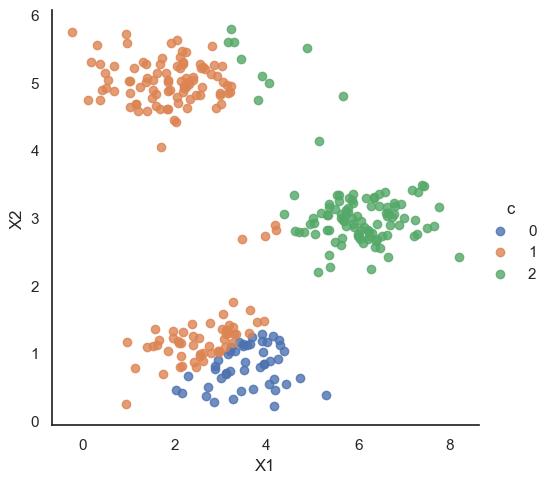

In [17]:
draw_res(data, k, 1)

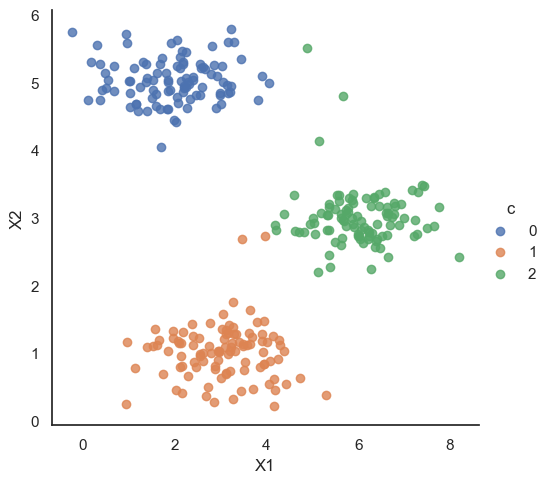

In [18]:
draw_res(data, k, 10)

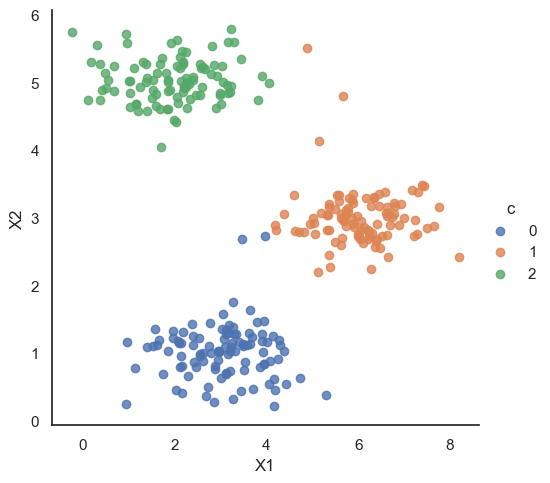

In [19]:
draw_res(data, k, 100)

到了这里似乎再增加 epcho 迭代次数没有什么明显的改进，我们尝试多次**随机初始化**

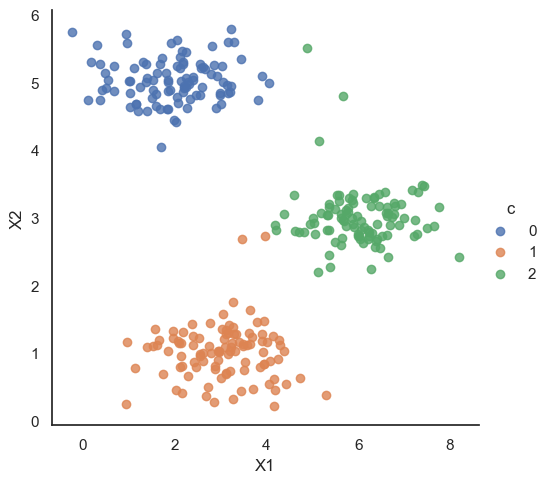

In [20]:
final_color, final_centorids, least_cost = k_means(data, k, 10)
data_with_color = combine_data_c(data, final_color)

sns.lmplot(x='X1', y='X2', hue='c', data=data_with_color, fit_reg=False)
plt.show()

结果已经比较完美了

## Sklearn K-means

其实也可以用SKlearn库来实现K-means

In [21]:
from sklearn.cluster import KMeans
sk_kmeans = KMeans(n_clusters=3, n_init='auto')
sk_kmeans.fit(data)

KMeans(n_clusters=3, n_init='auto')

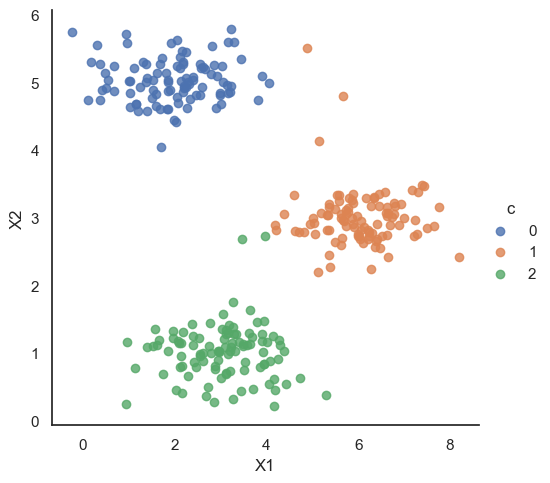

In [22]:
sk_c = sk_kmeans.predict(data)
data_with_c = combine_data_c(data, sk_c)
sns.lmplot(x='X1', y='X2', hue='c', data=data_with_c, fit_reg=False)
plt.show()

## Image Compression

我们的下一个任务是利用K-means对图像进行压缩。

原始的图片是一张 $128 \times 128$ RGB格式图片，每个像素点都包含3个8位的数字（共24位），分别表示red、green、blue的强度值\
我们要做的就是：将所有的颜色进行**K-means**，提取$16$个聚类，将所有颜色替换为其所属的聚簇点所示的颜色

In [23]:
from skimage import io

pic = io.imread('./data/bird_small.png')
pic = pic / 255 # normalize

pic.shape

(128, 128, 3)

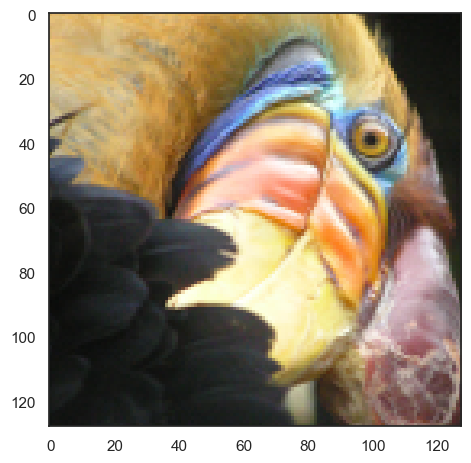

In [24]:
io.imshow(pic)

进行K-means

In [25]:
data = pic.reshape(128 * 128, 3)
data.shape

(16384, 3)

In [28]:
color, centorids, cost = k_means(pd.DataFrame(data), 16, epoch=10, n_init=5)
cost

0.07461788948500606

In [29]:
compressed_pic = centorids[color].reshape((128, 128, 3))

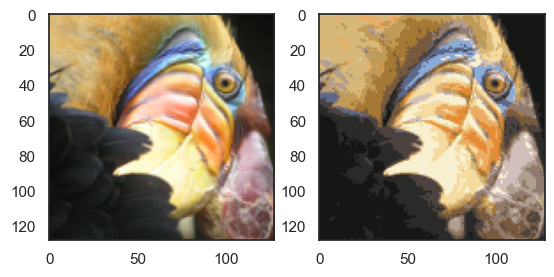

In [30]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()